# Contents:
1. Import Libraries
2. Import Data
3. Subsetting, Wrangling, and Cleaning Time-Series Data
4. Smoothing: Moving Average
5. Time-series analysis: Decomposition
6. Testing for stationarity
7. Stationarizing Time Series Data
8. Bonus Tasks

# 01. Import Libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

# 02. Import Data

In [2]:
# configure API key
quandl.ApiConfig.api_key = 'API'

In [3]:
# importing OPEC Crude Oil Price
data = quandl.get('OPEC/ORB')

In [4]:
data.head()

,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


In [6]:
data.shape

(5324, 1)

In [11]:
# create a sequence of expected dates
expected_dates = pd.date_range(start = data.index.min(), end = data.index.max(), freq = 'D')

In [12]:
# identify missing dates
missing_dates = expected_dates.difference(data.index)

In [13]:
# print missing dates
missing_dates

DatetimeIndex(['2003-01-04', '2003-01-05', '2003-01-11', '2003-01-12',
               '2003-01-18', '2003-01-19', '2003-01-25', '2003-01-26',
               '2003-02-01', '2003-02-02',
               ...
               '2023-07-22', '2023-07-23', '2023-07-29', '2023-07-30',
               '2023-08-05', '2023-08-06', '2023-08-12', '2023-08-13',
               '2023-08-19', '2023-08-20'],
              dtype='datetime64[ns]', length=2213, freq=None)

In [14]:
# resample to weekly frequency and calculate the mean as there are missing dates in datetime index
weekly_data  = data['Value'].resample('W').mean().reset_index()

In [15]:
weekly_data.head()

,Date,Value
0,2003-01-05,30.440
1,2003-01-12,29.724
2,2003-01-19,30.516
3,2003-01-26,30.748
4,2003-02-02,30.316


In [17]:
# set the 'Date' column as the index
weekly_data.set_index('Date', inplace = True)

In [18]:
weekly_data.columns

Index(['Value'], dtype='object')

In [19]:
type(weekly_data)

pandas.core.frame.DataFrame

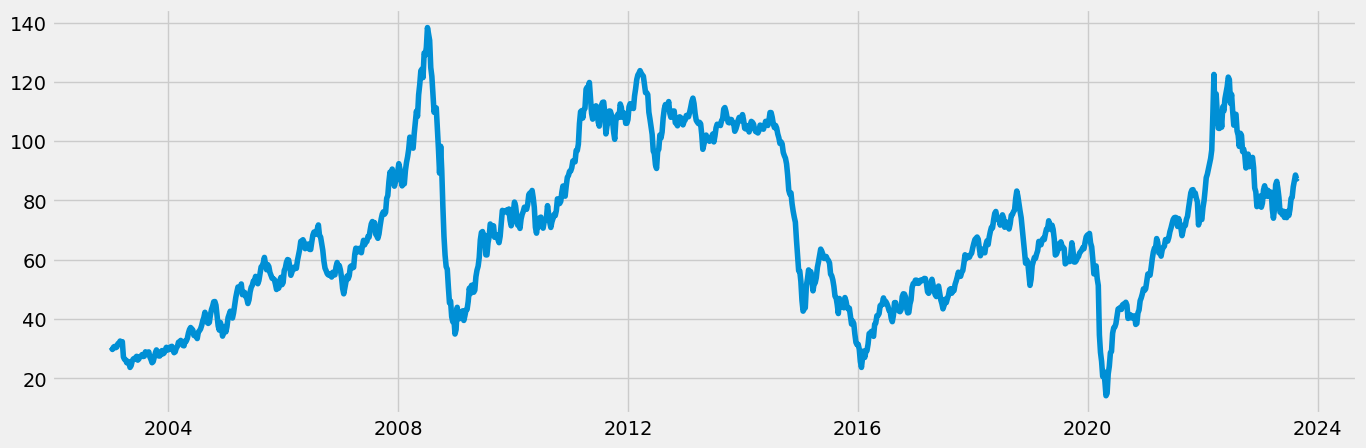

In [20]:
# plot the data using matplotlib
plt.figure(figsize=(15,5), dpi=100) # the dpi argument controls the quality of visualization here. When it is set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(weekly_data)


# 03. Subsetting, Wrangling, and Cleaning Time-Series Data

In [21]:
# reset the index of dataframe
data_2 = weekly_data.reset_index()

In [22]:
data_2.head()

,Date,Value
0,2003-01-05,30.440
1,2003-01-12,29.724
2,2003-01-19,30.516
3,2003-01-26,30.748
4,2003-02-02,30.316


In [23]:
# create a subset of the dataset containing records for the last 5 years
data_sub = data_2.loc[(data_2['Date'] >= '2018-05-16') & (data_2['Date'] <= '2023-08-15')]


In [24]:
data_sub.shape

(274, 2)

Rationale: Examining a span of five years of oil prices data offers a broader view of the price movements and patterns, enabling a thorough exploration to factors like seasonality, trends, market volatility, and recurring cycles. Within this timeframe, we can effectively capture short-term fluctuations and longer-term patterns in oil prices.

In [25]:
# set the 'Date' column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # create a datetime column from 'Date'
data_sub = data_sub.set_index('datetime') # set the datetime as the index of the dataframe
data_sub.drop(['Date'], axis=1, inplace = True) # drop the 'Date' column
data_sub.head()

,Value
datetime,
2018-05-20,75.616
2018-05-27,76.266
2018-06-03,73.888
2018-06-10,73.460
2018-06-17,73.612


In [26]:
# to check the frequency of the time series data based on the index value
freq = pd.infer_freq(data_sub.index)
print("freq", freq)

freq W-SUN


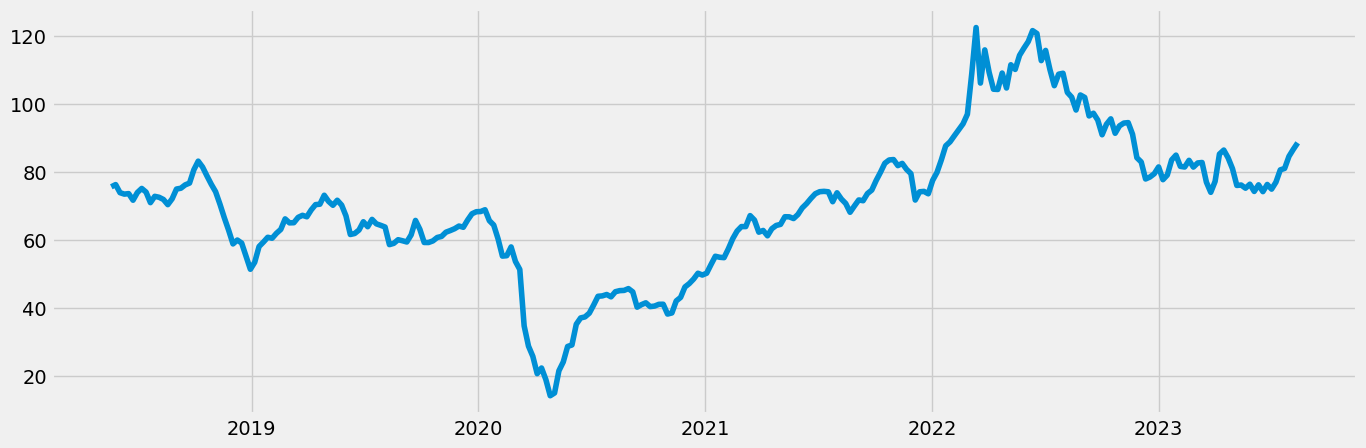

In [27]:
# plot the new dataset
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [28]:
# check for missing values 
data_sub.isnull().sum()

Value    0
dtype: int64

In [29]:
# check for duplicates
dups = data_sub.duplicated()
dups.sum()

# the occurrences that seem duplicated are not actual duplicates as they represent identical oil price values observed on different dates

1

# 04. Smoothing: Moving Average

In [67]:
# specify the window size for the moving average
window_size = 7

In [68]:
# calculate the moving average using rolling mean
data_sub_smoothed = data_sub['Value'].rolling(window = window_size).mean()

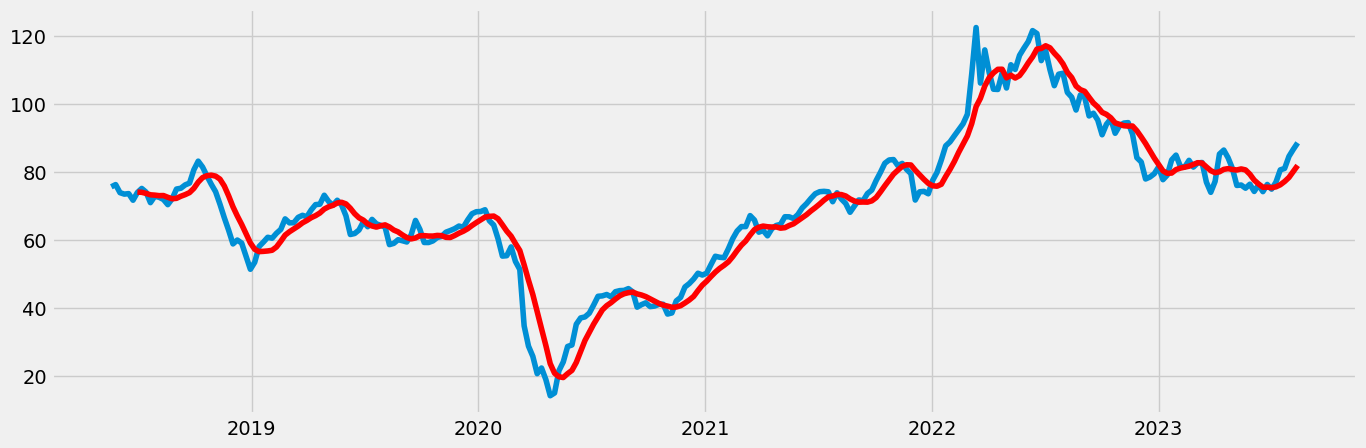

In [69]:
# plot the original data_sub and its smoothed data version
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub.index, data_sub['Value'], label='Original Weekly Data')
plt.plot(data_sub.index, data_sub_smoothed, label=f'Smoothed(MA, Window Size{window_size})', color='red')

# 05. Time-series analysis: Decomposition 

In [30]:
# decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [31]:
from pylab import rcParams # this will define a fixed size for all special charts
rcParams['figure.figsize'] = 18, 7

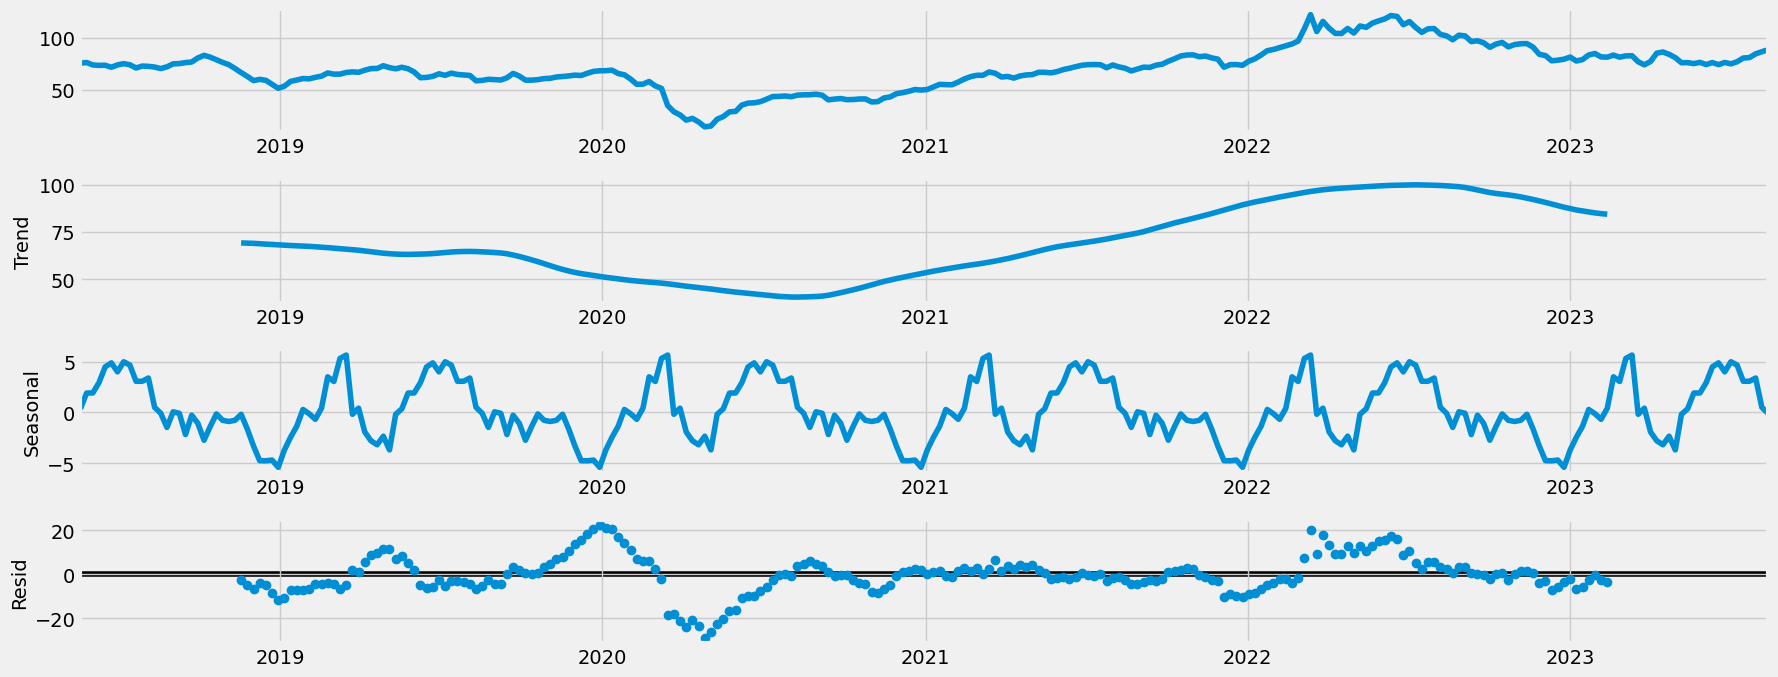

In [32]:
# plot the separate components
decomposition.plot()
plt.show()

# 06. Testing for stationarity

In [73]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.632460
p-value                          0.466203
Number of Lags Used              3.000000
Number of Observations Used    270.000000
Critical Value (1%)             -3.454804
Critical Value (5%)             -2.872305
Critical Value (10%)            -2.572506
dtype: float64


Observation: Employing a significance level of 5%, it is noticeable that the p-value stands at a relatively higher value, indicating that there is no strong evidence to reject the null hypothesis. Additionally, the test statistic is also larger than critical value. Considering both the high p-value and the absence of a more negative test statisctic in comparison to the critical value, we may not have enough evidence to reject the null hypothesis, suggesting that the time-series might exhibit non-stationary characteristics.

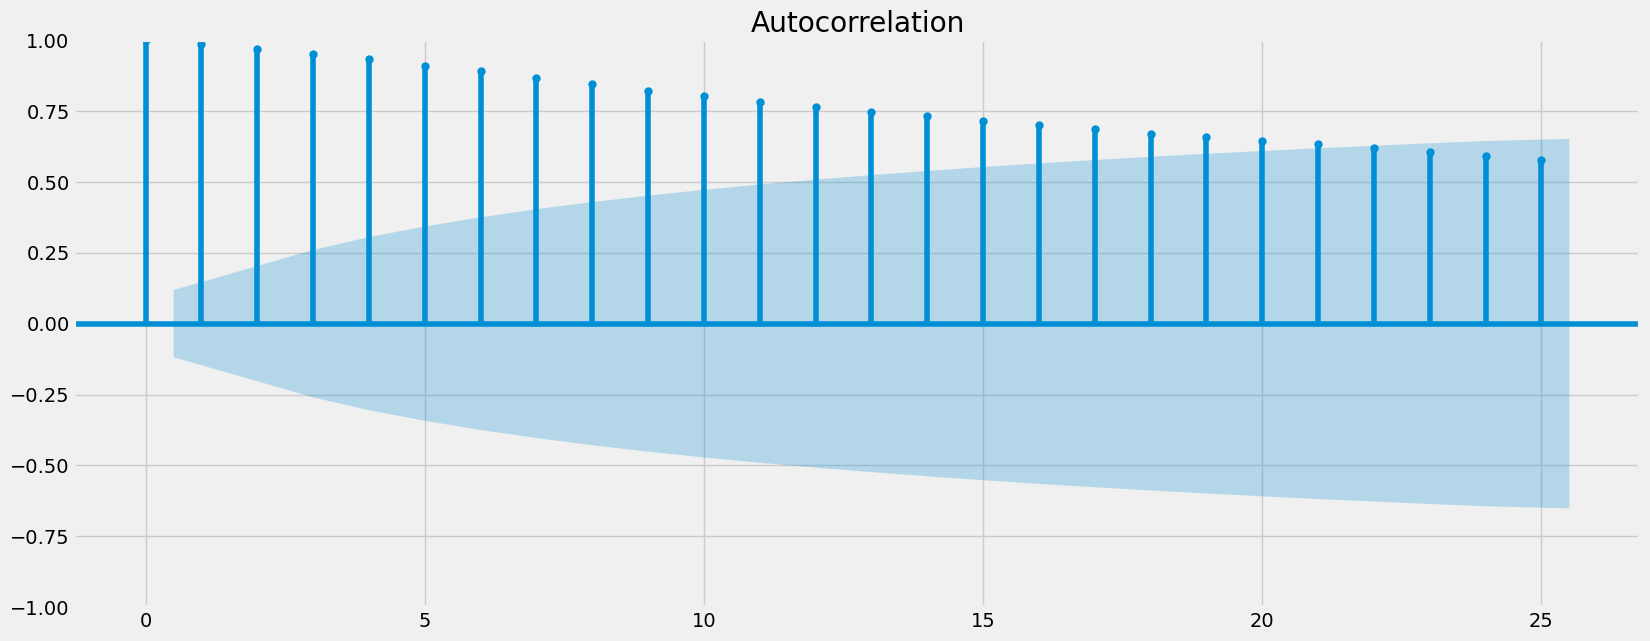

In [74]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

Observation: The autocorrelation plot indicates the presence of autocorrelated data, implying that the dataset is likely non-stationary. This observation aligns with the outcome of the Dickey-Fuller test.

# 07. Stationarizing Time Series Data

In [79]:
# calculate the first difference
data_diff = data_sub - data_sub.shift(1)

In [80]:
# remove the missing values that come about as a result of the differencing 
# need to remove these or we won't be able to run the DF test
data_diff.dropna(inplace=True)

In [81]:
data_diff.head()

,Value
datetime,
2018-05-27,0.650
2018-06-03,-2.378
2018-06-10,-0.428
2018-06-17,0.152
2018-06-24,-1.948


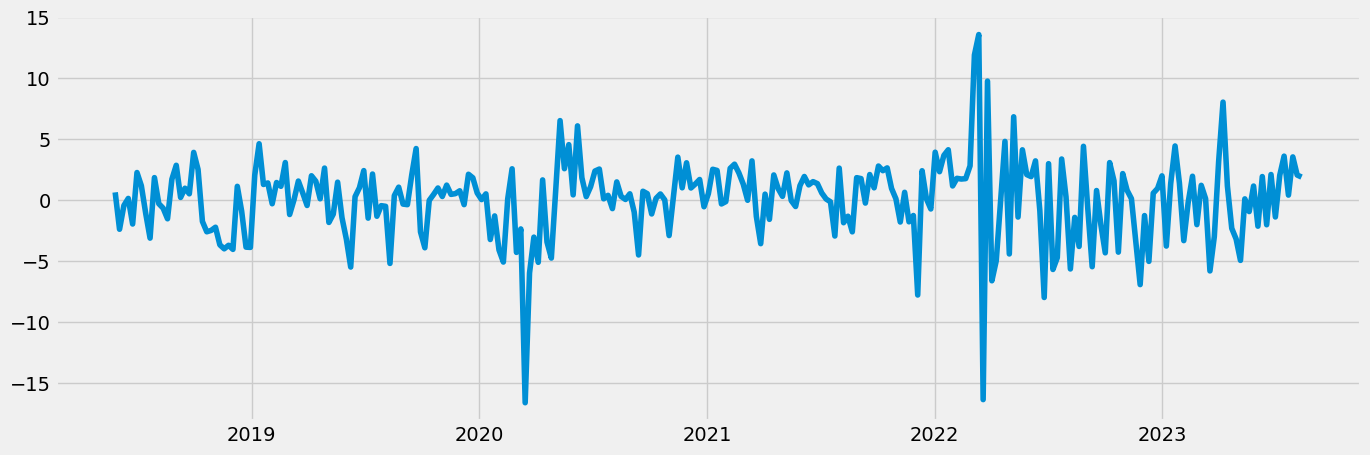

In [82]:
# plot what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [83]:
# apply the test using the function on the time series
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -7.552743e+00
p-value                        3.157200e-11
Number of Lags Used            2.000000e+00
Number of Observations Used    2.700000e+02
Critical Value (1%)           -3.454804e+00
Critical Value (5%)           -2.872305e+00
Critical Value (10%)          -2.572506e+00
dtype: float64


Observation: Employing a significance level of 5%, the p-value is significantly smaller, and the test statistics is substantially more negative compared to the critical value. This suggest that we have strong evidence to reject the null hypothesis, thereby concluding that stationarity is presence in the time series data

<function matplotlib.pyplot.show(close=None, block=None)>

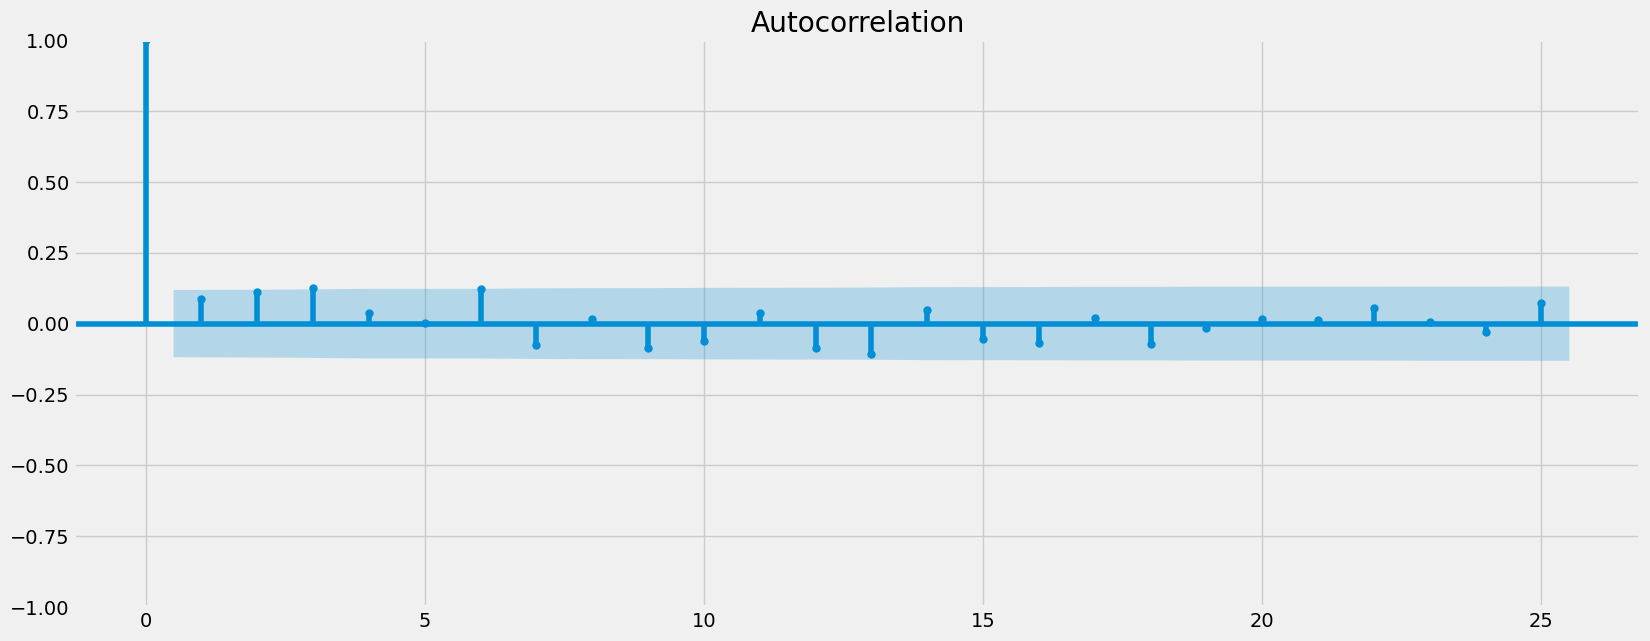

In [84]:
# plot the autocorrelations
plot_acf(data_diff)
plt.show

Observation: Our series is now stationary.

# 08. Bonus Tasks

## 01. Defining Parameters

<function matplotlib.pyplot.show(close=None, block=None)>

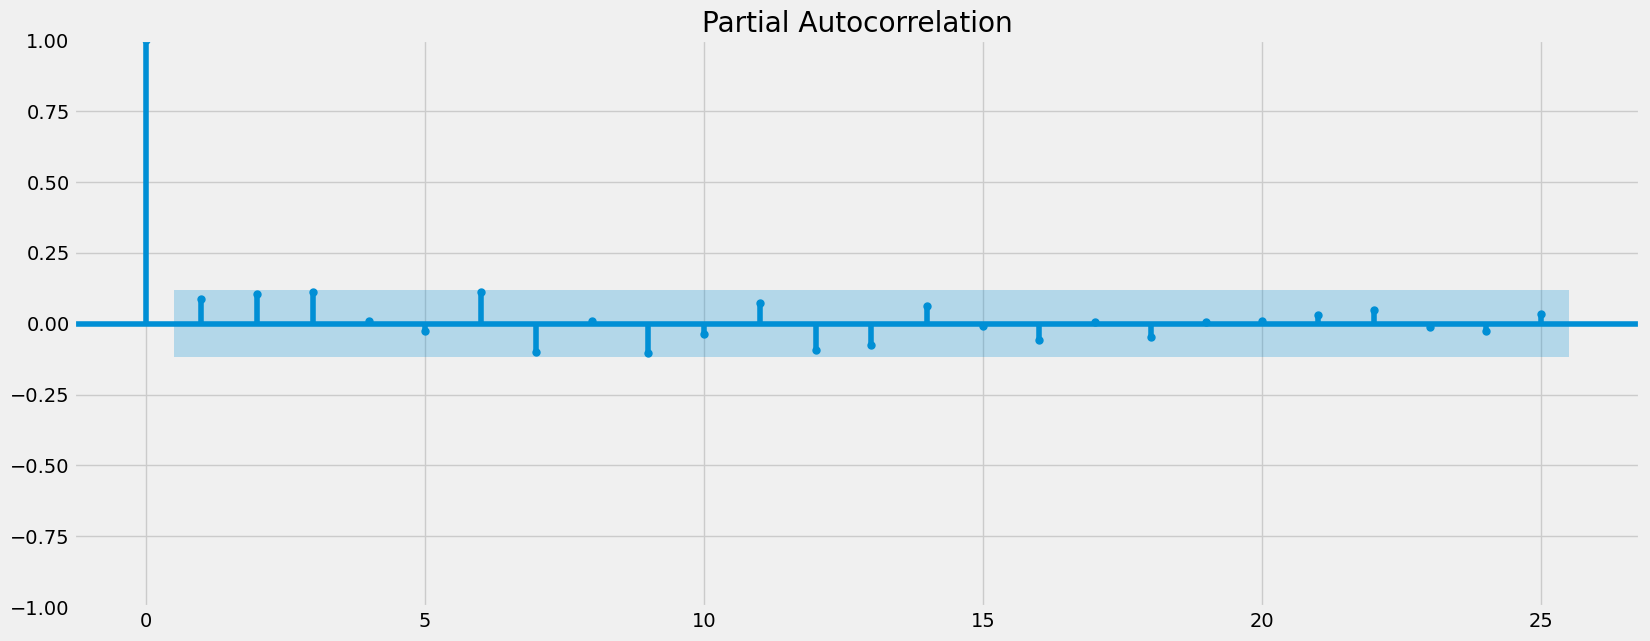

<Figure size 4500x4500 with 0 Axes>

In [86]:
# plot partial autocorrelations to determine parameter p
plot_pacf(data_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show

Observation: In the Partial Autocorrelation Function plot of differenced data, we are observing the correlation between the current differenced value and its lagged differenced value, while excluding the intervening correlations. The above plot shows that all peaks are not beyond the blue border (confidence interval), it indicates that there are no significant partial autocorrelations at any specific lag for the differenced data. This might suggest that the autoregressive (AR) component might not be a dominant factor in explaining the changes between successive differenced data points.

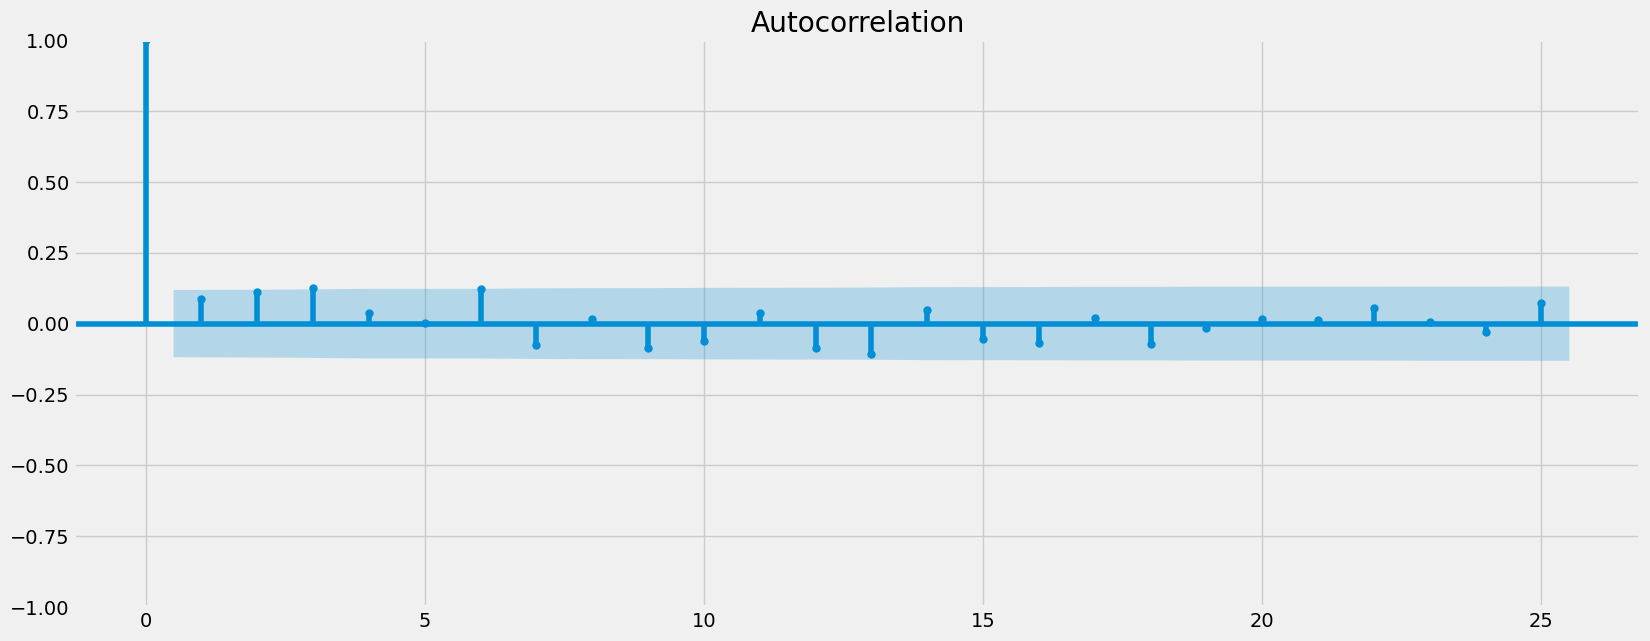

<Figure size 1500x500 with 0 Axes>

In [87]:
# plot autocorrelations to determine q

plot_acf(data_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

Observation: The Autocorrelation Function (ACF) plot of the differenced data also does not show significant peaks above the blue confidence interval bands, suggesting that the current data point is not strongly correlated with its lagged values. This indicates that the MA component might not be a dominant factor in explaining the variations in the data.

Conclusion: The autocorrelation structure in the differenced data is relatively weak and not well captured by a simple autoregressive (AR) or moving average (MA) component in an ARIMA model, therefore we could consider Seasonal ARIMA (SARIMA) model.